In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print("Downloading required NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ All libraries imported and NLTK data downloaded successfully!")

✅ All libraries imported and NLTK data downloaded successfully!


In [3]:
data_path = '../data/processed/merged_health_data.csv'

df = pd.read_csv(data_path)

print("="*60)
print("DATA LOADED SUCCESSFULLY")
print("="*60)
print(f"Total Records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 3 rows:")
print(df[['title', 'text', 'health_category']].head(3))

DATA LOADED SUCCESSFULLY
Total Records: 19,080
Columns: ['id', 'title', 'text', 'created_utc', 'score', 'num_comments', 'subreddit', 'category', 'health_category', 'source_file']

First 3 rows:
                 title                                               text  \
0  Diabetes and wounds  35. M. I've been a bad diabetic for a while, a...   
1        T1D in Movies  Curious, for the movie buffs on the sub, what ...   
2              Patches  Hi, I'm caring for someone who has very fragil...   

  health_category  
0        diabetes  
1        diabetes  
2        diabetes  


In [4]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

custom_stopwords = {
    'im', 'ive', 'dont', 'didnt', 'doesnt', 'isnt', 'arent', 'wasnt', 'werent',
    'hasnt', 'havent', 'hadnt', 'wont', 'wouldnt', 'couldnt', 'shouldnt',
    'cant', 'cannot', 'mightnt', 'mustnt', 'shant', 'shan',
    'id', 'youre', 'youve', 'youll', 'youd', 'hes', 'shes', 'its',
    'were', 'theyve', 'theyll', 'theyd', 'whats', 'wheres', 'whens',
    'whos', 'whys', 'hows', 'theres', 'heres',
    'reddit', 'post', 'edit', 'update', 'tldr', 'amp', 'x200b'
}

stop_words.update(custom_stopwords)

print("✅ Preprocessing tools initialized!")
print(f"Total stopwords: {len(stop_words)}")

✅ Preprocessing tools initialized!
Total stopwords: 244


In [5]:
def clean_text(text):
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text).lower()
    
    text = re.sub(r'\[deleted\]|\[removed\]', '', text)
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = re.sub(r'@\w+', '', text)
    
    text = re.sub(r'#\w+', '', text)
    
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\t', ' ', text)
    text = re.sub(r'\r', ' ', text)
    
    text = re.sub(r'&amp;|&lt;|&gt;|&quot;', '', text)
    
    text = re.sub(r'\d+', '', text)
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_text(text):
    if text == '':
        return []
    
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()
    
    return tokens

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return filtered_tokens

def lemmatize_tokens(tokens):
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized

def preprocess_text(text):
    cleaned = clean_text(text)
    
    tokens = tokenize_text(cleaned)
    
    tokens = remove_stopwords(tokens)
    
    tokens = lemmatize_tokens(tokens)
    
    processed_text = ' '.join(tokens)
    
    return processed_text

print("✅ Text cleaning functions defined!")
print("\nTesting on sample text:")
sample = "I'm really struggling with my diabetes! Check out this link: https://example.com #health @doctor123"
print(f"Original: {sample}")
print(f"Cleaned: {preprocess_text(sample)}")

✅ Text cleaning functions defined!

Testing on sample text:
Original: I'm really struggling with my diabetes! Check out this link: https://example.com #health @doctor123
Cleaned: really struggling diabetes check link


In [6]:
print("="*60)
print("STARTING TEXT PREPROCESSING")
print("="*60)
print("This may take several minutes for large datasets...")
print()

df['cleaned_text'] = df['text'].apply(preprocess_text)

df['cleaned_title'] = df['title'].apply(preprocess_text)

df['combined_text'] = df['cleaned_title'] + ' ' + df['cleaned_text']

df['combined_text'] = df['combined_text'].str.strip()

print("✅ Preprocessing completed!")
print(f"\nSample of cleaned data:")
print("-" * 60)

for idx in df.sample(3).index:
    print(f"\nOriginal: {df.loc[idx, 'text'][:150]}...")
    print(f"Cleaned:  {df.loc[idx, 'cleaned_text'][:150]}...")
    print("-" * 60)

STARTING TEXT PREPROCESSING
This may take several minutes for large datasets...

✅ Preprocessing completed!

Sample of cleaned data:
------------------------------------------------------------

Original: raw shredded beets, shredded carrots, grilled chicken, cottage cheese, red onions, sautéed bell peppers & broccoli, baked sweet potato. drizzle of pom...
Cleaned:  raw shredded beet shredded carrot grilled chicken cottage cheese red onion sautéed bell pepper broccoli baked sweet potato drizzle pomegranate molasse...
------------------------------------------------------------

Original: What are my options for addressing my narrow airway while I am awake? I have issues breathing and doing things like cardio because of my narrow airway...
Cleaned:  option addressing narrow airway awake issue breathing thing like cardio narrow airway nice addressed sleeping like address waking hour...
------------------------------------------------------------

Original: My personal go to tip if experi

In [7]:
print("="*60)
print("POST-PREPROCESSING STATISTICS")
print("="*60)

df['cleaned_length'] = df['cleaned_text'].apply(len)
df['cleaned_word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))

df['original_length'] = df['text'].fillna('').astype(str).apply(len)
df['original_word_count'] = df['text'].fillna('').astype(str).apply(lambda x: len(x.split()))

print(f"\nOriginal Data:")
print(f"  Average text length: {df['original_length'].mean():.0f} characters")
print(f"  Average word count: {df['original_word_count'].mean():.0f} words")

print(f"\nCleaned Data:")
print(f"  Average text length: {df['cleaned_length'].mean():.0f} characters")
print(f"  Average word count: {df['cleaned_word_count'].mean():.0f} words")

reduction_chars = ((df['original_length'].mean() - df['cleaned_length'].mean()) / df['original_length'].mean()) * 100
reduction_words = ((df['original_word_count'].mean() - df['cleaned_word_count'].mean()) / df['original_word_count'].mean()) * 100

print(f"\nReduction:")
print(f"  Characters: {reduction_chars:.1f}%")
print(f"  Words: {reduction_words:.1f}%")

empty_after_cleaning = len(df[df['cleaned_text'] == ''])
print(f"\nEmpty texts after cleaning: {empty_after_cleaning} ({empty_after_cleaning/len(df)*100:.2f}%)")

POST-PREPROCESSING STATISTICS

Original Data:
  Average text length: 812 characters
  Average word count: 145 words

Cleaned Data:
  Average text length: 477 characters
  Average word count: 71 words

Reduction:
  Characters: 41.3%
  Words: 51.2%

Empty texts after cleaning: 16 (0.08%)


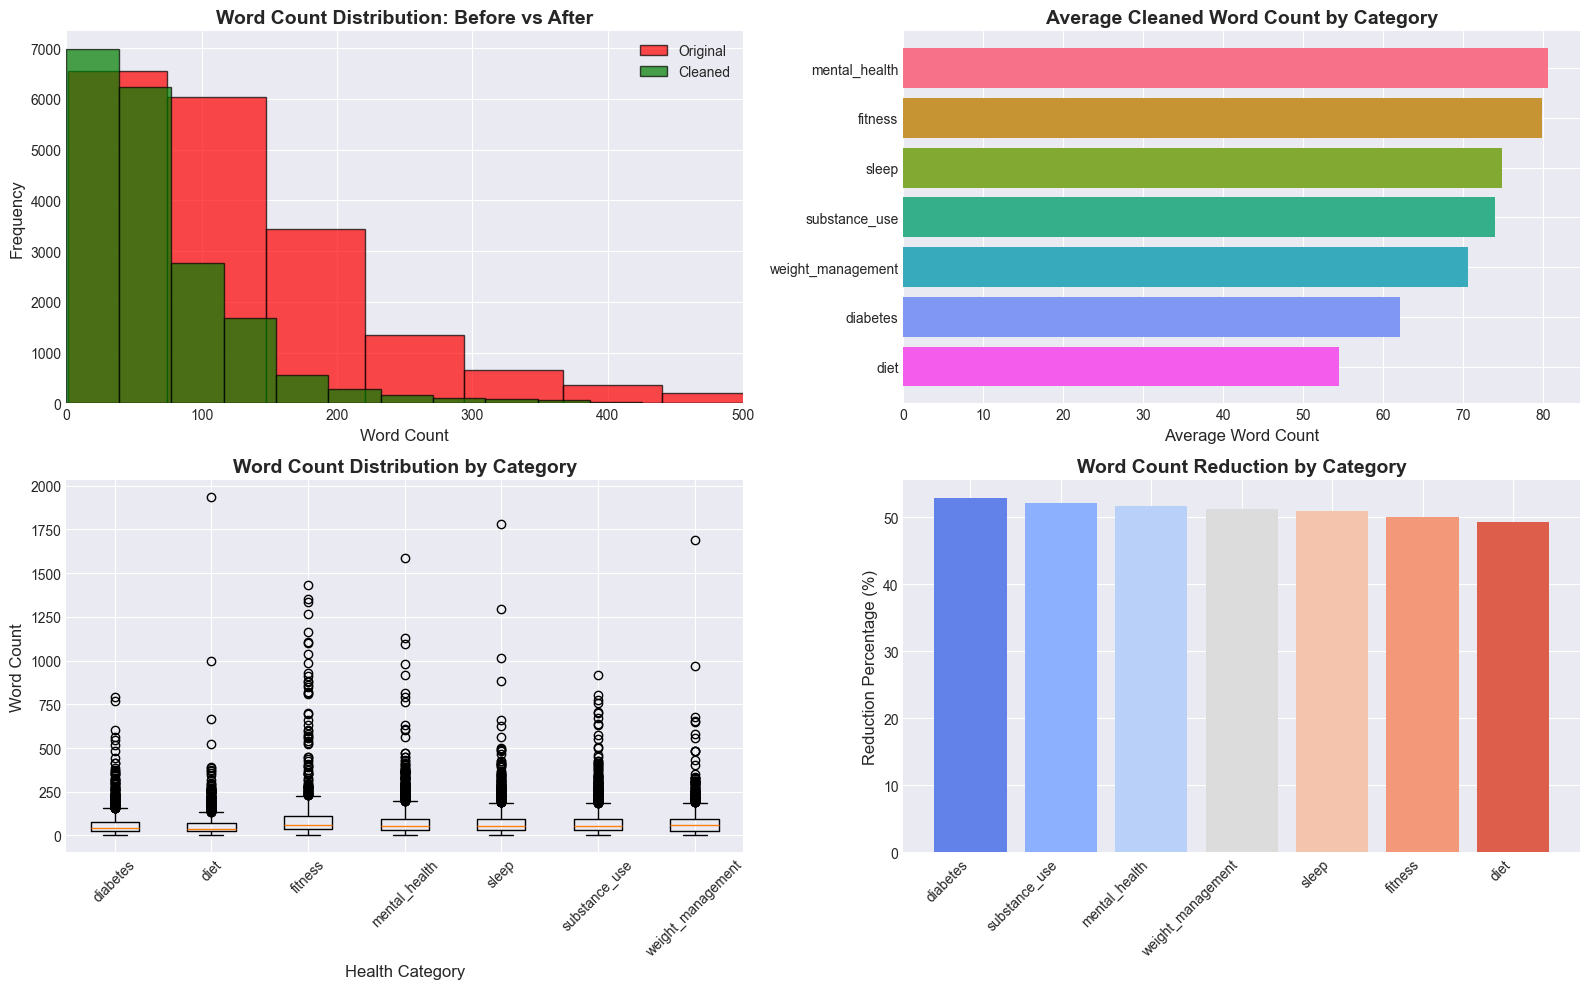

✅ Visualization saved to: reports/preprocessing_impact.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].hist(df['original_word_count'], bins=50, alpha=0.7, color='red', label='Original', edgecolor='black')
axes[0, 0].hist(df['cleaned_word_count'], bins=50, alpha=0.7, color='green', label='Cleaned', edgecolor='black')
axes[0, 0].set_xlabel('Word Count', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Word Count Distribution: Before vs After', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 500)

word_count_by_category = df.groupby('health_category')['cleaned_word_count'].mean().sort_values(ascending=False)
axes[0, 1].barh(range(len(word_count_by_category)), word_count_by_category.values, 
               color=sns.color_palette("husl", len(word_count_by_category)))
axes[0, 1].set_yticks(range(len(word_count_by_category)))
axes[0, 1].set_yticklabels(word_count_by_category.index)
axes[0, 1].set_xlabel('Average Word Count', fontsize=12)
axes[0, 1].set_title('Average Cleaned Word Count by Category', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()

df_non_empty = df[df['cleaned_text'] != '']
axes[1, 0].boxplot([df_non_empty[df_non_empty['health_category'] == cat]['cleaned_word_count'] 
                    for cat in df['health_category'].unique()],
                   labels=df['health_category'].unique())
axes[1, 0].set_xlabel('Health Category', fontsize=12)
axes[1, 0].set_ylabel('Word Count', fontsize=12)
axes[1, 0].set_title('Word Count Distribution by Category', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)

reduction_per_category = df.groupby('health_category').apply(
    lambda x: ((x['original_word_count'].mean() - x['cleaned_word_count'].mean()) / x['original_word_count'].mean()) * 100
).sort_values(ascending=False)

axes[1, 1].bar(range(len(reduction_per_category)), reduction_per_category.values,
              color=sns.color_palette("coolwarm", len(reduction_per_category)))
axes[1, 1].set_xticks(range(len(reduction_per_category)))
axes[1, 1].set_xticklabels(reduction_per_category.index, rotation=45, ha='right')
axes[1, 1].set_ylabel('Reduction Percentage (%)', fontsize=12)
axes[1, 1].set_title('Word Count Reduction by Category', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/preprocessing_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved to: reports/preprocessing_impact.png")

In [9]:
print("="*60)
print("VOCABULARY ANALYSIS")
print("="*60)

all_words = []
for text in df['cleaned_text']:
    if text != '':
        all_words.extend(text.split())

word_freq = Counter(all_words)
total_words = len(all_words)
unique_words = len(word_freq)

print(f"\nTotal words (after cleaning): {total_words:,}")
print(f"Unique words (vocabulary size): {unique_words:,}")
print(f"Average word frequency: {total_words/unique_words:.2f}")

print(f"\nTop 30 most common words:")
print("-" * 60)
for word, count in word_freq.most_common(30):
    percentage = (count / total_words) * 100
    print(f"{word:20s}: {count:6,} ({percentage:5.2f}%)")

VOCABULARY ANALYSIS

Total words (after cleaning): 1,354,316
Unique words (vocabulary size): 40,800
Average word frequency: 33.19

Top 30 most common words:
------------------------------------------------------------
like                : 14,111 ( 1.04%)
day                 : 12,821 ( 0.95%)
i’m                 : 10,992 ( 0.81%)
time                :  9,947 ( 0.73%)
get                 :  9,568 ( 0.71%)
feel                :  8,858 ( 0.65%)
sleep               :  8,198 ( 0.61%)
year                :  7,626 ( 0.56%)
know                :  7,278 ( 0.54%)
also                :  6,952 ( 0.51%)
question            :  6,553 ( 0.48%)
week                :  6,320 ( 0.47%)
would               :  6,222 ( 0.46%)
one                 :  6,199 ( 0.46%)
really              :  5,856 ( 0.43%)
i’ve                :  5,567 ( 0.41%)
thing               :  5,528 ( 0.41%)
want                :  5,473 ( 0.40%)
even                :  5,225 ( 0.39%)
make                :  5,160 ( 0.38%)
back                : 

In [10]:
print("="*60)
print("VOCABULARY ANALYSIS BY CATEGORY")
print("="*60)

category_vocab = {}

for category in df['health_category'].unique():
    category_text = ' '.join(df[df['health_category'] == category]['cleaned_text'].dropna())
    words = category_text.split()
    category_vocab[category] = {
        'total_words': len(words),
        'unique_words': len(set(words)),
        'top_words': Counter(words).most_common(10)
    }

for category, stats in category_vocab.items():
    print(f"\n{category.upper()}:")
    print(f"  Total words: {stats['total_words']:,}")
    print(f"  Unique words: {stats['unique_words']:,}")
    print(f"  Vocabulary richness: {stats['unique_words']/stats['total_words']*100:.2f}%")
    print(f"  Top 10 words:")
    for word, count in stats['top_words']:
        print(f"    {word:15s}: {count:5,}")

VOCABULARY ANALYSIS BY CATEGORY

DIABETES:
  Total words: 157,389
  Unique words: 12,104
  Vocabulary richness: 7.69%
  Top 10 words:
    like           : 1,388
    sugar          : 1,322
    i’m            : 1,310
    day            : 1,253
    blood          : 1,077
    insulin        : 1,060
    get            : 1,059
    year           :   999
    time           :   998
    know           :   969

DIET:
  Total words: 156,558
  Unique words: 12,297
  Vocabulary richness: 7.85%
  Top 10 words:
    like           : 1,605
    keto           : 1,598
    day            : 1,315
    food           : 1,163
    eat            : 1,153
    i’m            : 1,102
    protein        :   966
    time           :   861
    meal           :   849
    get            :   847

FITNESS:
  Total words: 231,052
  Unique words: 10,448
  Vocabulary richness: 4.52%
  Top 10 words:
    question       : 5,422
    thread         : 2,628
    like           : 2,267
    also           : 2,243
    search         

In [11]:
print("="*60)
print("FINAL DATA CLEANING")
print("="*60)

original_count = len(df)

df_clean = df[df['cleaned_text'] != ''].copy()

df_clean = df_clean[df_clean['cleaned_word_count'] >= 3].copy()

removed_count = original_count - len(df_clean)

print(f"Original dataset: {original_count:,} records")
print(f"After removing empty/short texts: {len(df_clean):,} records")
print(f"Removed: {removed_count:,} records ({removed_count/original_count*100:.2f}%)")

print(f"\nFinal dataset distribution:")
print(df_clean['health_category'].value_counts())

FINAL DATA CLEANING
Original dataset: 19,080 records
After removing empty/short texts: 19,060 records
Removed: 20 records (0.10%)

Final dataset distribution:
health_category
fitness              2892
diet                 2874
sleep                2766
substance_use        2763
mental_health        2715
diabetes             2531
weight_management    2519
Name: count, dtype: int64


TEXT QUALITY METRICS

Lexical Diversity Statistics:
  Mean: 0.855
  Median: 0.857
  Std Dev: 0.094

By Category:
  diabetes                 : 0.876
  substance_use            : 0.869
  diet                     : 0.869
  mental_health            : 0.855
  weight_management        : 0.854
  sleep                    : 0.843
  fitness                  : 0.825


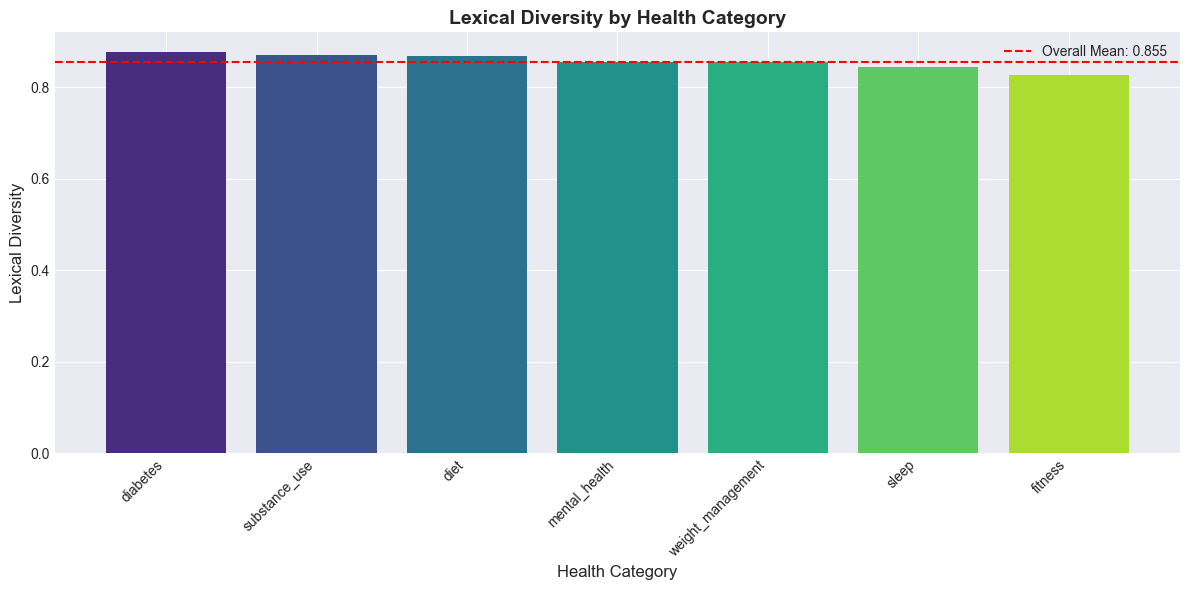


✅ Visualization saved to: reports/lexical_diversity.png


In [12]:
print("="*60)
print("TEXT QUALITY METRICS")
print("="*60)

def calculate_lexical_diversity(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return len(set(words)) / len(words)

df_clean['lexical_diversity'] = df_clean['cleaned_text'].apply(calculate_lexical_diversity)

print(f"\nLexical Diversity Statistics:")
print(f"  Mean: {df_clean['lexical_diversity'].mean():.3f}")
print(f"  Median: {df_clean['lexical_diversity'].median():.3f}")
print(f"  Std Dev: {df_clean['lexical_diversity'].std():.3f}")

print(f"\nBy Category:")
diversity_by_category = df_clean.groupby('health_category')['lexical_diversity'].mean().sort_values(ascending=False)
for category, diversity in diversity_by_category.items():
    print(f"  {category:25s}: {diversity:.3f}")

plt.figure(figsize=(12, 6))
plt.bar(range(len(diversity_by_category)), diversity_by_category.values,
       color=sns.color_palette("viridis", len(diversity_by_category)))
plt.xticks(range(len(diversity_by_category)), diversity_by_category.index, rotation=45, ha='right')
plt.ylabel('Lexical Diversity', fontsize=12)
plt.xlabel('Health Category', fontsize=12)
plt.title('Lexical Diversity by Health Category', fontsize=14, fontweight='bold')
plt.axhline(y=df_clean['lexical_diversity'].mean(), color='red', linestyle='--', 
           label=f'Overall Mean: {df_clean["lexical_diversity"].mean():.3f}')
plt.legend()
plt.tight_layout()
plt.savefig('../reports/lexical_diversity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved to: reports/lexical_diversity.png")

In [13]:
print("="*60)
print("CREATING ADDITIONAL FEATURES")
print("="*60)

df_clean['text_cleaned_length'] = df_clean['cleaned_text'].apply(len)

df_clean['avg_word_length'] = df_clean['cleaned_text'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if x else 0
)

df_clean['sentence_count'] = df_clean['text'].fillna('').apply(
    lambda x: len([s for s in re.split(r'[.!?]+', str(x)) if s.strip()])
)

df_clean['has_question'] = df_clean['text'].fillna('').str.contains(r'\?', regex=True).astype(int)

df_clean['has_exclamation'] = df_clean['text'].fillna('').str.contains(r'!', regex=True).astype(int)

df_clean['uppercase_ratio'] = df_clean['text'].fillna('').apply(
    lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0
)

print("✅ Additional features created!")
print(f"\nNew feature columns:")
feature_cols = ['text_cleaned_length', 'avg_word_length', 'sentence_count', 
                'has_question', 'has_exclamation', 'uppercase_ratio', 'lexical_diversity']
print(feature_cols)

print(f"\nSample statistics:")
print(df_clean[feature_cols].describe())

CREATING ADDITIONAL FEATURES
✅ Additional features created!

New feature columns:
['text_cleaned_length', 'avg_word_length', 'sentence_count', 'has_question', 'has_exclamation', 'uppercase_ratio', 'lexical_diversity']

Sample statistics:
       text_cleaned_length  avg_word_length  sentence_count  has_question  \
count         19060.000000     19060.000000    19060.000000  19060.000000   
mean            477.367681         5.696428       10.242078      0.602886   
std             545.198123         0.504391       11.469455      0.489313   
min              16.000000         3.750000        1.000000      0.000000   
25%             187.000000         5.362603        4.000000      0.000000   
50%             337.000000         5.655172        7.000000      1.000000   
75%             599.000000         6.000000       12.000000      1.000000   
max           13639.000000         9.666667      224.000000      1.000000   

       has_exclamation  uppercase_ratio  lexical_diversity  
count  

In [14]:
print("="*60)
print("SAVING PREPROCESSED DATA")
print("="*60)

columns_to_save = [
    'id', 'title', 'text', 'cleaned_title', 'cleaned_text', 'combined_text',
    'health_category', 'subreddit', 'score', 'num_comments', 'created_utc',
    'cleaned_word_count', 'text_cleaned_length', 'avg_word_length', 
    'sentence_count', 'has_question', 'has_exclamation', 
    'uppercase_ratio', 'lexical_diversity'
]

available_columns = [col for col in columns_to_save if col in df_clean.columns]

df_output = df_clean[available_columns].copy()

output_path = '../data/processed/preprocessed_data.csv'
df_output.to_csv(output_path, index=False)

print(f"✅ Preprocessed data saved to: {output_path}")
print(f"\nDataset shape: {df_output.shape}")
print(f"Columns saved: {len(available_columns)}")
print(f"\nColumn list:")
for col in available_columns:
    print(f"  - {col}")

SAVING PREPROCESSED DATA
✅ Preprocessed data saved to: ../data/processed/preprocessed_data.csv

Dataset shape: (19060, 19)
Columns saved: 19

Column list:
  - id
  - title
  - text
  - cleaned_title
  - cleaned_text
  - combined_text
  - health_category
  - subreddit
  - score
  - num_comments
  - created_utc
  - cleaned_word_count
  - text_cleaned_length
  - avg_word_length
  - sentence_count
  - has_question
  - has_exclamation
  - uppercase_ratio
  - lexical_diversity


In [15]:
print("="*60)
print("SAVING CATEGORY-WISE DATA FILES")
print("="*60)

category_output_dir = '../data/processed/by_category/'

import os
os.makedirs(category_output_dir, exist_ok=True)

for category in df_clean['health_category'].unique():
    category_df = df_clean[df_clean['health_category'] == category][available_columns]
    
    category_file = f"{category_output_dir}{category}_preprocessed.csv"
    category_df.to_csv(category_file, index=False)
    
    print(f"✅ Saved {category}: {len(category_df):,} records → {category_file}")

print(f"\n✅ All category files saved to: {category_output_dir}")

SAVING CATEGORY-WISE DATA FILES
✅ Saved diabetes: 2,531 records → ../data/processed/by_category/diabetes_preprocessed.csv
✅ Saved diet: 2,874 records → ../data/processed/by_category/diet_preprocessed.csv
✅ Saved fitness: 2,892 records → ../data/processed/by_category/fitness_preprocessed.csv
✅ Saved mental_health: 2,715 records → ../data/processed/by_category/mental_health_preprocessed.csv
✅ Saved sleep: 2,766 records → ../data/processed/by_category/sleep_preprocessed.csv
✅ Saved substance_use: 2,763 records → ../data/processed/by_category/substance_use_preprocessed.csv
✅ Saved weight_management: 2,519 records → ../data/processed/by_category/weight_management_preprocessed.csv

✅ All category files saved to: ../data/processed/by_category/


In [16]:
print("="*80)
print(" " * 25 + "PREPROCESSING SUMMARY REPORT")
print("="*80)

print("\n📊 DATA TRANSFORMATION:")
print("-" * 80)
print(f"  Original dataset: {original_count:,} records")
print(f"  Final dataset: {len(df_clean):,} records")
print(f"  Records removed: {removed_count:,} ({removed_count/original_count*100:.2f}%)")

print("\n📝 TEXT STATISTICS:")
print("-" * 80)
print(f"  Average cleaned text length: {df_clean['text_cleaned_length'].mean():.0f} characters")
print(f"  Average cleaned word count: {df_clean['cleaned_word_count'].mean():.0f} words")
print(f"  Average word length: {df_clean['avg_word_length'].mean():.2f} characters")
print(f"  Average lexical diversity: {df_clean['lexical_diversity'].mean():.3f}")

print("\n📚 VOCABULARY:")
print("-" * 80)
print(f"  Total words (corpus): {total_words:,}")
print(f"  Unique words (vocabulary): {unique_words:,}")
print(f"  Vocabulary richness: {unique_words/total_words*100:.2f}%")

print("\n📈 CATEGORY DISTRIBUTION (FINAL):")
print("-" * 80)
for category, count in df_clean['health_category'].value_counts().items():
    percentage = (count / len(df_clean)) * 100
    print(f"  {category:25s}: {count:6,} records ({percentage:5.2f}%)")

print("\n💡 FEATURE ENGINEERING:")
print("-" * 80)
print(f"  Features created: {len(feature_cols)}")
print("  Features list:")
for feat in feature_cols:
    print(f"    - {feat}")

print("\n📁 OUTPUT FILES:")
print("-" * 80)
print(f"  ✅ Main file: {output_path}")
print(f"  ✅ Category files: {len(df_clean['health_category'].unique())} files in {category_output_dir}")
print(f"  ✅ Visualizations:")
print(f"     - preprocessing_impact.png")
print(f"     - lexical_diversity.png")

print("\n🎯 PREPROCESSING PIPELINE STEPS COMPLETED:")
print("-" * 80)
print("  ✅ Text cleaning (URLs, special chars, punctuation)")
print("  ✅ Tokenization")
print("  ✅ Stopword removal (English + custom)")
print("  ✅ Lemmatization")
print("  ✅ Empty text removal")
print("  ✅ Feature engineering")
print("  ✅ Data validation")
print("  ✅ Category-wise file generation")

print("\n" + "="*80)
print(" " * 25 + "PREPROCESSING COMPLETED SUCCESSFULLY! ✅")
print("="*80)

                         PREPROCESSING SUMMARY REPORT

📊 DATA TRANSFORMATION:
--------------------------------------------------------------------------------
  Original dataset: 19,080 records
  Final dataset: 19,060 records
  Records removed: 20 (0.10%)

📝 TEXT STATISTICS:
--------------------------------------------------------------------------------
  Average cleaned text length: 477 characters
  Average cleaned word count: 71 words
  Average word length: 5.70 characters
  Average lexical diversity: 0.855

📚 VOCABULARY:
--------------------------------------------------------------------------------
  Total words (corpus): 1,354,316
  Unique words (vocabulary): 40,800
  Vocabulary richness: 3.01%

📈 CATEGORY DISTRIBUTION (FINAL):
--------------------------------------------------------------------------------
  fitness                  :  2,892 records (15.17%)
  diet                     :  2,874 records (15.08%)
  sleep                    :  2,766 records (14.51%)
  substance_use

In [17]:
print("="*60)
print("FINAL DATA QUALITY CHECK")
print("="*60)

print("\n✓ Checking for null values in key columns:")
key_columns = ['cleaned_text', 'health_category', 'combined_text']
for col in key_columns:
    null_count = df_clean[col].isnull().sum()
    print(f"  {col}: {null_count} nulls")

print("\n✓ Checking for empty strings:")
empty_cleaned = len(df_clean[df_clean['cleaned_text'] == ''])
empty_combined = len(df_clean[df_clean['combined_text'] == ''])
print(f"  cleaned_text: {empty_cleaned} empty strings")
print(f"  combined_text: {empty_combined} empty strings")

print("\n✓ Checking word count distribution:")
very_short = len(df_clean[df_clean['cleaned_word_count'] < 5])
short = len(df_clean[(df_clean['cleaned_word_count'] >= 5) & (df_clean['cleaned_word_count'] < 20)])
medium = len(df_clean[(df_clean['cleaned_word_count'] >= 20) & (df_clean['cleaned_word_count'] < 100)])
long = len(df_clean[df_clean['cleaned_word_count'] >= 100])

print(f"  Very short (<5 words): {very_short:,} ({very_short/len(df_clean)*100:.1f}%)")
print(f"  Short (5-19 words): {short:,} ({short/len(df_clean)*100:.1f}%)")
print(f"  Medium (20-99 words): {medium:,} ({medium/len(df_clean)*100:.1f}%)")
print(f"  Long (100+ words): {long:,} ({long/len(df_clean)*100:.1f}%)")

print("\n✓ Checking category balance:")
min_category_size = df_clean['health_category'].value_counts().min()
max_category_size = df_clean['health_category'].value_counts().max()
balance_ratio = min_category_size / max_category_size
print(f"  Smallest category: {min_category_size:,} samples")
print(f"  Largest category: {max_category_size:,} samples")
print(f"  Balance ratio: {balance_ratio:.3f}")
if balance_ratio < 0.3:
    print(f"  ⚠️ Warning: Significant class imbalance detected!")
else:
    print(f"  ✅ Categories are reasonably balanced")

print("\n" + "="*60)
print("DATA QUALITY CHECK COMPLETED! ✅")
print("="*60)

FINAL DATA QUALITY CHECK

✓ Checking for null values in key columns:
  cleaned_text: 0 nulls
  health_category: 0 nulls
  combined_text: 0 nulls

✓ Checking for empty strings:
  cleaned_text: 0 empty strings
  combined_text: 0 empty strings

✓ Checking word count distribution:
  Very short (<5 words): 37 (0.2%)
  Short (5-19 words): 2,595 (13.6%)
  Medium (20-99 words): 12,378 (64.9%)
  Long (100+ words): 4,050 (21.2%)

✓ Checking category balance:
  Smallest category: 2,519 samples
  Largest category: 2,892 samples
  Balance ratio: 0.871
  ✅ Categories are reasonably balanced

DATA QUALITY CHECK COMPLETED! ✅
